# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pprint
import operator
import time
from sklearn.preprocessing import Imputer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA    
from sklearn.preprocessing import LabelEncoder
# !pip install mca
# import mca
import chardet
# magic word for producing visualizations in notebook
%matplotlib inline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import f1_score, roc_auc_score

In [1]:
!pip install lightgbm
import lightgbm as lgb

    100% |████████████████████████████████| 1.2MB 12.1MB/s ta 0:00:01


## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [3]:
# load in the data
# azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';', dtype=str)
# customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';', dtype=str)
azdias = pd.read_csv('Udacity_AZDIAS_052018.csv', sep=';', dtype=str)
customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=';', dtype=str)

In [3]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!

In [4]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9,0,NaN,NaN,NaN,NaN,21,11,...,4,8,11,10,3,9,4,5,2,1
2,910225,-1,9,17,NaN,NaN,NaN,NaN,17,10,...,2,9,9,6,3,9,2,5,2,3
3,910226,2,1,13,NaN,NaN,NaN,NaN,13,1,...,0,7,10,11,NaN,9,7,3,2,4
4,910241,-1,1,20,NaN,NaN,NaN,NaN,14,3,...,2,3,5,4,2,9,3,4,1,3


In [5]:
azdias["LNR"].nunique()

891221

It seems like each row has unique LNR value.

In [6]:
customers["LNR"].nunique() == customers.shape[0]

True

In [7]:
np.intersect1d(azdias["LNR"], customers["LNR"])

array([], dtype=object)

In [8]:
with open("dias.csv.csv", "rb") as dias:
    dias_content = dias.read()
    print(chardet.detect(dias_content))

{'encoding': 'Windows-1252', 'confidence': 0.73, 'language': ''}


In [9]:
dias = pd.read_csv("dias.csv.csv", encoding="Windows-1252")

In [10]:
dias.head(20)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,NaN,NaN,1,< 30 years
7,NaN,NaN,2,30 - 45 years
8,NaN,NaN,3,46 - 60 years
9,NaN,NaN,4,> 60 years


In [11]:
dias = dias.fillna(method="ffill")

In [12]:
dias.head(20)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,ALTERSKATEGORIE_GROB,age classification through prename analysis,1,< 30 years
7,ALTERSKATEGORIE_GROB,age classification through prename analysis,2,30 - 45 years
8,ALTERSKATEGORIE_GROB,age classification through prename analysis,3,46 - 60 years
9,ALTERSKATEGORIE_GROB,age classification through prename analysis,4,> 60 years


In [13]:
attribute_names = dias[["Attribute", "Description"]].drop_duplicates()

In [14]:
attribute_desc = {}

In [15]:
for index, row in attribute_names.iterrows():
    attribute_desc[row[0]] = row[1]

In [16]:
attribute_desc

{'AGER_TYP': 'best-ager typology',
 'ALTERSKATEGORIE_GROB': 'age classification through prename analysis ',
 'ALTER_HH': 'main age within the household',
 'ANREDE_KZ': 'gender',
 'ANZ_HAUSHALTE_AKTIV': 'number of households in the building',
 'ANZ_HH_TITEL': 'number of academic title holder in building',
 'ANZ_PERSONEN': 'number of adult persons in the household',
 'ANZ_TITEL': 'number of professional title holder in household ',
 'BALLRAUM': 'distance to next urban centre ',
 'BIP_FLAG': 'business-flag indicating companies in the building',
 'CAMEO_DEUG_2015': 'CAMEO classification 2015 - Uppergroup',
 'CAMEO_DEU_2015': 'CAMEO classification 2015 - detailled classification',
 'CAMEO_DEUINTL_2015': '(each German CAMEO code belongs to one international code)',
 'CJT_GESAMTTYP': 'customer journey typology',
 'D19_BANKEN_ANZ_12': 'transaction activity BANKS in the last 12 months',
 'D19_BANKEN_ANZ_24': 'transaction activity BANKS in the last 24 months',
 'D19_BANKEN_DATUM': 'actuality of 

## Dealing with missing data

Identify the missing values represented by -1,0 or 9 and replace them with NaN in dataframe.

In [17]:
# cust = customers.copy()

In [18]:
# df = azdias.copy()

In [19]:
# df = df.rename(columns = attribute_desc)

In [20]:
# dias.Value.dtype

In [21]:
# dias.query("Meaning == 'unknown'").head()

In [22]:
# for index, row in dias.query("Meaning == 'unknown'").iterrows():
#     Attribute, Description, Value, Meaning = row
#     if Description in df.columns:
#         values = Value.split(",")
#         replacement = {}
#         for value in values:
#             value = value.strip()
#             replacement[value] = None
#         df.loc[:, Description].replace(replacement, inplace=True)

In [23]:
# df.head()

In [24]:
#df.replace({"-1": None}, inplace=True)

In [25]:
#df.to_csv("parsed_pop.csv", index=None, header=True)

In [26]:
#col_select = (df.isna().sum(axis=0)/df.shape[0]) <= 0.20
#col_select

In [27]:
#df_few_missing = df.loc[:, col_select]

In [28]:
#df.shape

In [29]:
#df_few_missing.shape

In [30]:
#df_few_missing.nunique().sort_values(ascending=False)

In [31]:
#df_limited_levels = df_few_missing.loc[:, df_few_missing.nunique() <= 30]

In [32]:
#df_limited_levels.shape

In [33]:
#df_not_x = df_limited_levels.loc[:, :].replace({'X': None, 'XX': None})

In [34]:
#def fill_mode(col):
#    return col.fillna(col.mode()[0])
#df_filled = df_not_x.apply(fill_mode, axis=0)
    

In [35]:
# numbers = [str(x) for x in range(100)]
# for col in df_filled.columns:
#     try:
#         for value in df_filled[col].unique():
#             if value not in numbers:
#                 print(col + " " + str(df_filled[col].unique()))
#     except:
#         print(col + " represents DataFrame")

In [36]:
#df_filled["share of other cars within the PLZ8"].head()

In [37]:
#df_filled["share of upper middle class cars and upper class cars (BMW5er, BMW7er etc.)"].head()

In [38]:
#df_filled = df_filled.loc[:, ~df_filled.columns.duplicated()]

In [39]:
#df_filled.head(100)

In [40]:
#df_filled.isna().sum().sort_values(ascending=False)

In [41]:
#if "flag indicating the former GDR/FRG" in list(df_filled.columns):
#    df_filled.loc[:, "flag indicating the former GDR/FRG"].replace({'W':0, 'O': 1}, inplace=True)

In [42]:
#df_num = df_filled.astype(int)

In [43]:
#del df_num, df_filled

In [44]:
# def clean_data(df_input):    
#     df = df_input.copy()
#     print ("Copied")
# #     df = df.rename(columns = attribute_desc)
# #     print ("Renamed columns")
# #     df = df.loc[:, ~df.columns.duplicated()]
# #     print ("Removed duplicate columns")
#     for index, row in dias.query("Meaning == 'unknown'").iterrows():
#         Attribute, Description, Value, Meaning = row
#         if Attribute in df.columns:
#             values = Value.split(",")
#             replacement = {}
#             for value in values:
#                 value = value.strip()
#                 replacement[value] = None
#             df.loc[:, Attribute].replace(replacement, inplace=True)
#     print("Replaced unknown with None")
#     df.replace({"-1": None}, inplace=True)
#     print ("Replaced -1 with None")
#     col_select = (df.isna().sum(axis=0)/df.shape[0]) <= 0.20    
#     df = df.loc[:, col_select]
#     print ("Retained columns with only few missing values")
#     df = df.loc[:, df.nunique() <= 30]
#     print ("Retained columns with limited levels")
#     df = df.loc[:, :].replace({'X': None, 'XX': None})
#     print ("Replaced X and XX with None")
#     def fill_mode(col):
#         return col.fillna(col.mode()[0])
#     df = df.apply(fill_mode, axis=0)
#     print ("Filled Nan with Mode")
    
#     numbers = [str(x) for x in range(100)]
#     for col in df.columns:
#         level = 0
#         for value in df[col].unique():
#             if value not in numbers:
#                 df.loc[df[col] == value, col] = level
#                 print(col + " " + str(df[col].unique()))                
#                 print("Replaced {} with {}".format(value, level))
#                 level += 1
#     df = df.astype(int)
#     print ("Converted to numeric")
#     return df

In [45]:
# common_cols = np.intersect1d(customers.columns, azdias.columns)

In [46]:
# cust = clean_data(customers[common_cols])

In [47]:
# pop = clean_data(azdias[common_cols])

In [48]:
# cust.to_csv("cust.csv", index=False, header=True, sep=";")

In [49]:
# pop.to_csv("pop.csv", index=False, header=True, sep=";")

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [50]:
cust = pd.read_csv("cust.csv", sep=";")
pop = pd.read_csv("pop.csv", sep=";")

In [51]:
cust.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,...,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,ZABEOTYP
0,4,1,5,4,1,1,5,5,5,5,...,4,7,6,2,1,2,6,1,6,3
1,4,1,6,5,1,1,5,5,5,5,...,4,5,6,4,1,2,3,1,7,3
2,4,2,2,5,2,2,5,5,5,5,...,1,7,3,4,2,1,2,1,3,3
3,4,1,2,5,1,1,5,5,5,5,...,4,5,4,3,3,3,6,4,7,1
4,3,1,6,4,3,3,3,4,3,3,...,5,6,6,5,5,4,4,4,5,1


In [52]:
pop.head()

,AKT_DAT_KL,ALTERSKATEGORIE_GROB,ALTER_HH,ANREDE_KZ,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,...,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,WOHNDAUER_2008,WOHNLAGE,W_KEIT_KIND_HH,ZABEOTYP
0,1,2,0,1,0,0,1,0,4,6,...,2,0,2,10,10,10,9,3,6,3
1,9,1,0,2,0,0,2,0,3,6,...,2,0,4,8,11,10,9,4,3,5
2,9,3,17,2,0,0,1,0,3,2,...,1,0,2,9,9,6,9,2,3,5
3,1,4,13,2,0,0,0,0,2,4,...,1,1,0,7,10,11,9,7,6,3
4,1,3,20,1,0,0,4,0,4,2,...,2,0,2,3,5,4,9,3,2,4


In [53]:
scaler = StandardScaler()

In [54]:
common_cols = np.intersect1d(pop.columns, cust.columns)

In [55]:
pop_float = pop[common_cols].astype(float)

In [56]:
pop_scaled = pd.DataFrame(scaler.fit_transform(pop_float.values), columns=pop_float.columns)

In [57]:
pop_float.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,...,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,ZABEOTYP
0,2.0,1.0,2.0,5.0,1.0,1.0,5.0,5.0,5.0,5.0,...,3.0,5.0,5.0,5.0,4.0,7.0,2.0,3.0,1.0,3.0
1,1.0,2.0,5.0,1.0,5.0,5.0,2.0,3.0,1.0,1.0,...,3.0,2.0,3.0,7.0,6.0,4.0,5.0,6.0,1.0,5.0
2,3.0,2.0,3.0,2.0,4.0,4.0,1.0,3.0,2.0,2.0,...,3.0,4.0,3.0,3.0,4.0,3.0,4.0,3.0,4.0,5.0
3,4.0,2.0,2.0,3.0,2.0,2.0,4.0,4.0,5.0,3.0,...,4.0,4.0,1.0,4.0,3.0,2.0,5.0,4.0,4.0,3.0
4,3.0,1.0,5.0,3.0,3.0,3.0,3.0,4.0,3.0,3.0,...,6.0,4.0,2.0,4.0,2.0,4.0,6.0,2.0,7.0,4.0


In [58]:
pop_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,...,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,ZABEOTYP
0,-0.727373,-1.045218,-1.027618,1.107775,-1.735176,-1.570560,1.172932,1.203659,1.181001,1.147432,...,-0.538400,0.316841,0.537487,0.420264,0.056863,1.374629,-0.999639,-0.387544,-1.455284,-0.267936
1,-1.663024,0.956738,0.858107,-1.568545,1.184799,1.278729,-0.973028,-0.251101,-1.716472,-1.860914,...,-0.538400,-1.166231,-0.539206,1.550121,1.322441,-0.119863,0.541539,1.369271,-1.455284,1.210585
2,0.208278,0.956738,-0.399043,-0.899465,0.454805,0.566407,-1.688349,-0.251101,-0.992104,-1.108827,...,-0.538400,-0.177517,-0.539206,-0.709593,0.056863,-0.618027,0.027813,-0.387544,-0.011411,1.210585
3,1.143930,0.956738,-1.027618,-0.230385,-1.005182,-0.858238,0.457612,0.476279,1.181001,-0.356741,...,-0.013139,-0.177517,-1.615900,-0.144664,-0.575926,-1.116191,0.541539,0.198061,-0.011411,-0.267936
4,0.208278,-1.045218,0.858107,-0.230385,-0.275189,-0.145915,-0.257708,0.476279,-0.267735,-0.356741,...,1.037383,-0.177517,-1.077553,-0.144664,-1.208715,-0.119863,1.055265,-0.973149,1.432462,0.471325


In [59]:
cust_float = cust[common_cols].astype(float)

In [60]:
cust_scaled = pd.DataFrame(scaler.transform(cust_float.values), columns=cust_float.columns)

In [61]:
pca = PCA(random_state=42)

In [62]:
pop_pca = pca.fit_transform(pop_scaled)

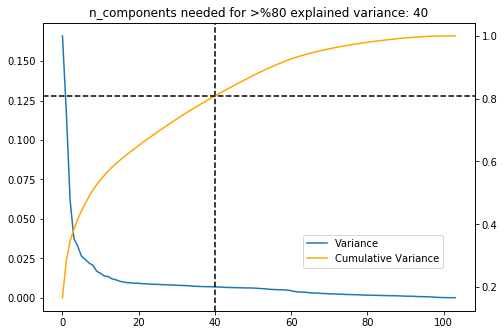

In [63]:
# Investigate the variance accounted for by each principal component.
# Number of components required to maintain %80 variance:
n_components = min(np.where(np.cumsum(pca.explained_variance_ratio_)>0.8)[0]+1)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1],True)
ax2 = ax.twinx()
ax.plot(pca.explained_variance_ratio_, label='Variance',)
ax2.plot(np.cumsum(pca.explained_variance_ratio_), label='Cumulative Variance',color = 'orange');
ax.set_title('n_components needed for >%80 explained variance: {}'.format(n_components));
ax.axvline(n_components, linestyle='dashed', color='black')
ax2.axhline(np.cumsum(pca.explained_variance_ratio_)[n_components], linestyle='dashed', color='black')
fig.legend(loc=(0.6,0.2));

In [64]:
pca = PCA(n_components=n_components, random_state=42)

In [65]:
pop_pca = pca.fit_transform(pop_float)

In [66]:
pca.explained_variance_ratio_.sum()

0.884356184932581

In [67]:
def get_kmeans_score(data, k):
    kmeans = KMeans(n_clusters=k, random_state=42)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    return score

In [68]:
# scores = []
# ks = list(range(2,31))
# for k in ks:
#     scores.append(get_kmeans_score(pop_pca, k))

In [69]:
# plt.plot(ks, scores, marker='o');
# plt.xlabel('K');
# plt.ylabel('SSE');
# plt.title('SSE vs. K');

In [70]:
k = 20

In [71]:
kmeans = KMeans(n_clusters=k, random_state=42, n_jobs=-1)

In [72]:
model_pop = kmeans.fit(pop_pca)

In [73]:
pop_pred = model_pop.predict(pop_pca) + 1

In [74]:
cust_pca = pca.transform(cust_scaled)

In [75]:
cust_pred = model_pop.predict(cust_pca) + 1

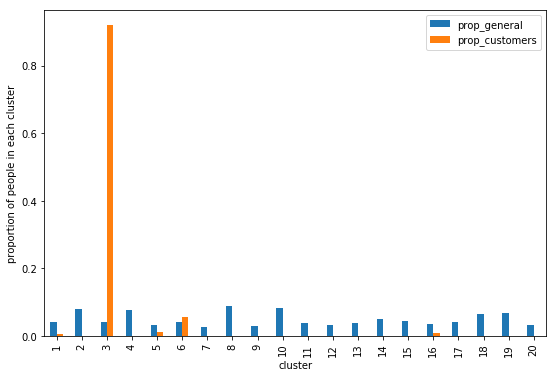

In [76]:
general_prop = []
customers_prop = []
x = range(1, k+1)
for i in range(1, k+1):
    general_prop.append((pop_pred == i).sum()/len(pop_pred))
    customers_prop.append((cust_pred == i).sum()/len(cust_pred))


df_prop = pd.DataFrame({'cluster' : x, 'prop_general' : general_prop, 'prop_customers':customers_prop})

#ax = sns.countplot(x='index', y = df_general['prop_1', 'prop_2'], data=df_general )
df_prop.plot(x='cluster', y = ['prop_general', 'prop_customers'], kind='bar', figsize=(9,6))
plt.ylabel('proportion of people in each cluster')
plt.show()

In [77]:
df_prop["diff"] = (df_prop["prop_customers"] - df_prop["prop_general"])/df_prop["prop_general"]

In [78]:
df_prop["diff"]

0     -0.848751
1     -1.000000
2     21.146209
3     -1.000000
4     -0.640687
5      0.283660
6     -1.000000
7     -1.000000
8     -1.000000
9     -1.000000
10    -1.000000
11    -1.000000
12    -1.000000
13    -1.000000
14    -1.000000
15    -0.762588
16    -1.000000
17    -1.000000
18    -1.000000
19    -1.000000
Name: diff, dtype: float64

In [79]:
sorted_by_diff = df_prop.sort_values(by=["diff"], ascending=False)["cluster"]

In [80]:
most_likely_cust_cluster = sorted_by_diff.iloc[0]

In [81]:
most_likely_cust_cluster

3

In [82]:
least_likely_cust_cluster = sorted_by_diff.iloc[-1]

In [83]:
pd.Series(cust_pred).value_counts()

3     176057
6      10533
5       2222
16      1654
1       1186
dtype: int64

In [84]:
(cust_pred == most_likely_cust_cluster).sum()

176057

In [85]:
cust_in_most_likely_cust_cluster = cust_pca[cust_pred == most_likely_cust_cluster]

In [86]:
cust_in_most_likely_cust_cluster[:5]

array([[ 1.08504712e+01, -1.78490303e+00, -1.35642683e+01,
         6.77922257e+00, -2.39685120e+00, -9.89738897e+00,
         5.31521338e+00, -6.92422161e+00,  3.50994376e+00,
         1.69212664e+00, -9.86437622e-01, -1.59804717e-02,
         3.15318880e+00,  5.30518056e+00, -4.91491005e-01,
         4.25818879e+00,  9.44007808e+00,  5.32505876e+00,
         4.96538897e+00, -3.91385165e+00, -5.79966500e-01,
        -4.02629594e-01,  8.16453568e-01,  2.20959780e+00,
         4.41344204e+00,  6.82947710e+00, -6.27194347e-01,
         2.51978390e-01,  2.23921474e+00, -1.15647536e+00,
        -2.48064339e+00,  1.36689251e+00, -2.84446037e+00,
        -2.95942125e+00,  5.87089420e+00, -1.68900785e+00,
        -2.66940045e+00, -3.06819052e-01, -3.79408499e+00,
        -1.01360857e+00],
       [ 1.01095749e+01,  6.39070719e-01, -1.45779628e+01,
         5.91691456e+00, -2.91682449e+00, -1.24234255e+01,
         4.83079176e+00, -7.19460608e+00,  5.89004564e+00,
         1.86203373e+00, -1.96

In [87]:
cust_in_least_likely_cust_cluster = cust_pca[cust_pred == least_likely_cust_cluster, :]

In [88]:
def pca_weights(pca, i):
    weight_map = {}
    for counter, feature in enumerate(common_cols):
        weight_map[feature] = pca.components_[i][counter]
    
    sorted_weights = sorted(weight_map.items(), key=operator.itemgetter(1), reverse=True)
    
    return sorted_weights

In [89]:
import math
min_std = math.inf
min_comp = None
for comp in range(0, cust_in_most_likely_cust_cluster.shape[1]):
    comp_std = cust_in_most_likely_cust_cluster[:, comp].std()
    if comp_std < min_std:
        min_std = comp_std
    min_comp = comp


In [90]:
min_comp

39

In [91]:
comp_significance = pd.DataFrame({"comp": range(pop_pca.shape[1]), "dist_in_std" : (cust_in_most_likely_cust_cluster.mean(axis=0) - pop_pca.mean(axis=0))/pop_pca.std(axis=0)})

In [92]:
comp_significance.head()

,comp,dist_in_std
0,0,1.267687
1,1,0.248261
2,2,-2.941206
3,3,0.726646
4,4,-0.613209


In [93]:
comp_significance["abs_dist_in_std"] = comp_significance["dist_in_std"].abs()

In [94]:
comp_sorted = comp_significance.sort_values(by=["abs_dist_in_std"], ascending=False)

In [95]:
comp_sorted

,comp,dist_in_std,abs_dist_in_std
25,25,5.152463,5.152463
16,16,4.910675,4.910675
34,34,3.948753,3.948753
5,5,-3.196972,3.196972
24,24,2.949236,2.949236
2,2,-2.941206,2.941206
36,36,-2.833887,2.833887
17,17,2.453253,2.453253
38,38,-2.373885,2.373885
7,7,-2.320085,2.320085


In [96]:
for comp in comp_sorted.iloc[:5, 0]:
    print ("Component: {}".format(comp))
    pprint.pprint(pca_weights(pca, comp))

Component: 25
[('D19_KONSUMTYP_MAX', 0.4788872842075688),
 ('D19_VERSICHERUNGEN', 0.31046222279633284),
 ('D19_BUCH_CD', 0.1889677949416108),
 ('D19_GESAMT_ANZ_12', 0.14841902200067597),
 ('D19_VERSAND_ANZ_12', 0.11365914795000792),
 ('D19_BANKEN_ANZ_24', 0.09765467315519276),
 ('D19_BANKEN_ANZ_12', 0.09158179336736094),
 ('D19_VERSAND_ANZ_24', 0.09121622912216983),
 ('D19_BEKLEIDUNG_REST', 0.0886392073147963),
 ('D19_GESAMT_ANZ_24', 0.08546495955681112),
 ('D19_KINDERARTIKEL', 0.07676864709486883),
 ('CJT_TYP_4', 0.05837213673895584),
 ('D19_HANDWERK', 0.05552903135974059),
 ('D19_SONSTIGE', 0.05337711880232582),
 ('D19_SCHUHE', 0.04870220749466881),
 ('D19_FREIZEIT', 0.045499242420096175),
 ('D19_TELKO_ANZ_24', 0.03725513476722222),
 ('D19_VOLLSORTIMENT', 0.036358731044242365),
 ('D19_TELKO_ANZ_12', 0.02978063220295727),
 ('FINANZ_VORSORGER', 0.026438438618849026),
 ('CJT_TYP_5', 0.026198632553146715),
 ('FINANZ_ANLEGER', 0.02327763160249843),
 ('D19_VERSAND_REST', 0.0202154093680640

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [5]:
training = pd.read_csv("Udacity_MAILOUT_052018_TRAIN.csv", sep=";", dtype="str")

In [6]:
training.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1,8,NaN,NaN,NaN,NaN,8,15,...,5,2,1,6,9,3,3,0,2,4
1,1771,1,4,13,NaN,NaN,NaN,NaN,13,1,...,1,2,1,4,9,7,1,0,2,3
2,1776,1,1,9,NaN,NaN,NaN,NaN,7,0,...,6,4,2,NaN,9,2,3,0,1,4
3,1460,2,1,6,NaN,NaN,NaN,NaN,6,4,...,8,11,11,6,9,1,3,0,2,4
4,1783,2,1,9,NaN,NaN,NaN,NaN,9,53,...,2,2,1,6,9,3,3,0,1,3


In [7]:
# df = training.copy()

In [8]:
# for index, row in dias.query("Meaning == 'unknown'").iterrows():
#     Attribute, Description, Value, Meaning = row
#     if Attribute in df.columns:
#         values = Value.split(",")
#         replacement = {}
#         for value in values:
#             value = value.strip()
#             replacement[value] = None
#         df.loc[:, Attribute].replace(replacement, inplace=True)

In [9]:
# df.replace({"-1": None}, inplace=True)

In [10]:
# df = df.loc[:, :].replace({'X': None, 'XX': None})

In [11]:
# df_for_cls = df[common_cols].copy()

In [12]:
azdias_cleaned = azdias.copy()

In [15]:
feat_info = pd.read_csv("features.csv")

In [17]:
feat_info.head()

,version https://git-lfs.github.com/spec/v1
0,oid sha256:b2b5efca9d3bf639ded053f115a329dc564...
1,size 14709


In [16]:
for index, row in feat_info.iterrows():
        attribute, information_level, var_type, missing, comment = row
        if attribute in df.columns:
            values = missing.replace("[","").replace("]","").split(",")
            replacement = {}
            for value in values:
                value = value.strip()
                replacement[value] = None
            df.loc[:, attribute].replace(replacement, inplace=True)

ValueError: not enough values to unpack (expected 5, got 1)

In [13]:
# for index, row in dias.query("Meaning == 'unknown'").iterrows():
#     Attribute, Description, Value, Meaning = row
#     if Attribute in azdias_cleaned.columns:
#         values = Value.split(",")
#         replacement = {}
#         for value in values:
#             value = value.strip()
#             replacement[value] = None
#         azdias_cleaned.loc[:, Attribute].replace(replacement, inplace=True)

NameError: name 'dias' is not defined

In [ ]:
azdias_cleaned.replace({"-1": None, 'X': None, 'XX': None}, inplace=True)

In [ ]:
# azdias_cleaned = azdias_cleaned.loc[:, :].replace({'X': None, 'XX': None})

In [ ]:
# for col in df_for_cls.columns:
#     df_for_cls.loc[:, col] = df_for_cls[col].fillna(value=azdias_cleaned[col].mode()[0])

In [ ]:
# numbers = [str(x) for x in range(100)]
# for col in df_for_cls.columns:
#     level = 0
#     for value in df_for_cls[col].unique():
#         if value not in numbers:
#             df_for_cls.loc[df_for_cls[col] == value, col] = level
#             print(col + " " + str(df_for_cls[col].unique()))                
#             print("Replaced {} with {}".format(value, level))
#             level += 1
# df_for_cls = df_for_cls.astype(float)

In [ ]:
# def clean_sl_data(df, azdias_cleaned=azdias_cleaned, common_cols=common_cols, dias=dias):
#     df = df.copy()
#     for index, row in dias.query("Meaning == 'unknown'").iterrows():
#         Attribute, Description, Value, Meaning = row
#         if Attribute in df.columns:
#             values = Value.split(",")
#             replacement = {}
#             for value in values:
#                 value = value.strip()
#                 replacement[value] = None
#             df.loc[:, Attribute].replace(replacement, inplace=True)
#     df.replace({"-1": None, 'X': None, 'XX': None}, inplace=True)
#     df_for_cls = df[common_cols].copy()
#     for col in df_for_cls.columns:
#         df_for_cls.loc[:, col] = df_for_cls[col].fillna(value=azdias_cleaned[col].mode()[0])
#     numbers = [str(x) for x in range(100)]
#     for col in df_for_cls.columns:
#         level = 0
#         for value in df_for_cls[col].unique():
#             if value not in numbers:
#                 df_for_cls.loc[df_for_cls[col] == value, col] = level
#                 print(col + " " + str(df_for_cls[col].unique()))                
#                 print("Replaced {} with {}".format(value, level))
#                 level += 1
#     df_for_cls = df_for_cls.astype(float)
#     return df, df_for_cls

In [ ]:
feat_info.head()

In [ ]:
def clean_sl_data(df, azdias_cleaned=azdias_cleaned, common_cols=common_cols, dias=dias):
    df = df.copy()
    cat_cols = []
    num_cols = []
    for index, row in feat_info.iterrows():
        attribute, information_level, var_type, missing, comment = row
        if var_type in ["interval", "categorical"]:
            cat_cols.append(attribute)
        elif var_type in ["ordinal", "numeric"]:
            num_cols.append(attribute)
        if attribute in df.columns:
            values = missing.replace("[","").replace("]","").split(",")
            replacement = {}
            for value in values:
                value = value.strip()
                replacement[value] = None
            df.loc[:, attribute].replace(replacement, inplace=True)
#     df.replace({"-1": None, 'X': None, 'XX': None}, inplace=True)
    recode = ['D19_BANKEN_DATUM', 'D19_BANKEN_OFFLINE_DATUM',
       'D19_BANKEN_ONLINE_DATUM', 'D19_GESAMT_DATUM',
       'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM',
       'D19_TELKO_DATUM', 'D19_TELKO_OFFLINE_DATUM',
       'D19_TELKO_ONLINE_DATUM', 'D19_VERSAND_DATUM',
       'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM',
       'D19_VERSI_DATUM', 'D19_VERSI_OFFLINE_DATUM',
       'D19_VERSI_ONLINE_DATUM']
    df[recode] = df[recode].replace("10", "0")
    
#     df_for_cls = df[common_cols].copy()
    df_for_cls = df_for_cls.drop(columns=["LNR"])
    df_for_cls = df_for_cls[[col for col in azdias_cleaned.columns if col in df_for_cls.columns]]
    for col in df_for_cls.columns:
        df_for_cls.loc[:, col] = df_for_cls[col].fillna(value=azdias_cleaned[col].mode()[0])   
    numbers = [str(x) for x in range(100)]
    
    for col in df_for_cls.columns:
        level = 0
        for value in df_for_cls[col].unique():
            if value not in numbers:
                df_for_cls.loc[df_for_cls[col] == value, col] = level
                print(col + " " + str(df_for_cls[col].unique()))                
                print("Replaced {} with {}".format(value, level))
                level += 1
        
#     num_cols = [col for col in num_cols if col in common_cols]
#     cat_cols = [col for col in cat_cols if col in common_cols]
#     df_for_cls[num_cols] = df_for_cls[num_cols].astype(float)
#     for col in cat_cols:
#         df_for_cls = pd.concat([df_for_cls.drop(columns=[col]), pd.get_dummies(df_for_cls[col].astype(str))], axis=1)
#     pd.get_dummies(df_for_cls[cat_cols]) = df_for_cls[cat_cols].astype(str)
    df_for_cls = df_for_cls.astype(float)
    return df, df_for_cls

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataCleaner(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, input_array, y=None):
        return self
    
    def transform(self, input_array, y=None):
        return clean_sl_data(df=input_array)[1]

In [ ]:
# training_cleaned, training_for_cls_cleaned = clean_sl_data(training)

In [ ]:
class PopScaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, input_array, y=None):
        return self
    
    def transform(self, input_array, y=None):
        return scaler.transform(input_array)

In [ ]:
class PopPCA(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, input_array, y=None):
        return self
    
    def transform(self, input_array, y=None):
        return pca.transform(input_array)

In [ ]:
pca_pipeline = Pipeline([
    ("cleaner", DataCleaner()),
    ("normalizer", PopScaler()),
    ("pca", PopPCA())
])

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class IdentityTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, input_array, y=None):
        return self
    
    def transform(self, input_array, y=None):
        return input_array

In [ ]:
class ClusterAssigner(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, input_array, y=None):
        return self
    
    def transform(self, input_array, y=None):
#         cluster_df = pd.DataFrame(model_pop.predict(input_array), columns=["cluster"])
#         cluster_numeric_df = pd.get_dummies(cluster_df)
#         return cluster_numeric_df.values
       return model_pop.predict(input_array).reshape(-1, 1)

In [ ]:
class CommonColsSelector(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, input_array, y=None):
        return self
    
    def transform(self, input_array, y=None):
        return input_array[common_cols]

In [ ]:
from sklearn.preprocessing import OneHotEncoder
class CatToNumeric(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.ohe = OneHotEncoder(categories='auto')
        pass
    
    def fit(self, input_array, y=None):
        self.ohe.fit(np.array(range(k)).reshape(-1, 1))
        return self
    
    def transform(self, input_array, y=None):
        return self.ohe.transform(input_array)
        

In [ ]:
# from sklearn.pipeline import FeatureUnion
# from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.feature_selection import SelectKBest, chi2
# from sklearn.preprocessing import OneHotEncoder

# clf_pipeline = Pipeline([
#             ("common_cols_selector", CommonColsSelector()),            
#             ("features", FeatureUnion([
#                 ("scaled_k_best", Pipeline([
#                     ("cleaner", DataCleaner()),
#                     ("k_best", SelectKBest(chi2, 10)),
#                     ("scaler", StandardScaler())
#                 ])),
#                 ("pca", pca_pipeline),
#                 ("cluster", Pipeline([
#                     ("pca", pca_pipeline),
#                     ("cluster_assigner", ClusterAssigner()),
#                     ("one_hot_encoder", CatToNumeric())
#                 ]))
#             ])),
#             ("clf", SVC(gamma=0.001, C=100, random_state=42))
    
# ])
# cv_pipeline = GridSearchCV(param_grid = {
#     "features__scaled_k_best__k_best__k": [10],
# #     "clf__min_samples_leaf": [3],
#     "clf__C": [100],
#     "clf__gamma": [0.0001]
# }, estimator = clf_pipeline, cv = 2, scoring="f1")

In [ ]:
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
clf_pipeline = Pipeline([
            ("common_cols_selector", CommonColsSelector()),            
            ("cleaner", DataCleaner()),
            ("clf", AdaBoostClassifier(DecisionTreeClassifier()))
    
])
cv_pipeline = GridSearchCV(param_grid = {
    'clf__learning_rate': [0.1],
      'clf__n_estimators':[50],
      'clf__random_state': [42],
#       'clf__base_estimator__max_depth': [10, None],
        'clf__min_samples_leaf': [3],
      'clf__base_estimator__max_features': [20, None]
}, estimator = clf_pipeline, cv = 3, scoring="roc_auc")

In [ ]:
X = training.drop(columns=["RESPONSE"])
Y = training["RESPONSE"].astype(int)
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, random_state=42)

In [ ]:
# from  sklearn.metrics import roc_auc_score
# best = {
    
# }
# max_auc = -math.inf
# # for k_best in [10, 20, 30]:
# max_f1 = -math.inf
# for gamma in [0.05]:
#     for C in [100]:
#         clf_pipeline_1 = Pipeline([
#             ("common_cols_selector", CommonColsSelector()),            
#             ("pca", pca_pipeline),
#             ("features", FeatureUnion([
#         #                     ("scaled_k_best", Pipeline([
#         #                         ("cleaner", DataCleaner()),
#         #                         ("k_best", SelectKBest(chi2, k=k_best)),
#         #                         ("scaler", StandardScaler())
#         #                     ])),
#                         ("identity", IdentityTransformer()),
#                         ("cluster", Pipeline([
#                             ("cluster_assigner", ClusterAssigner()),
#                             ("one_hot_encoder", CatToNumeric())
#                         ]))
#             ])),
# #             ("clf", SVC(C=C, gamma=gamma, random_state=42, probability=True))
#             ("clf", SVC(C=C, gamma=gamma, random_state=42))            
#         ])       
#         clf_pipeline_1.fit(X_train, Y_train)
#         Y_pred = clf_pipeline_1.predict(X_test)
# #         Y_pred_proba = clf_pipeline_1.predict_proba(X_test)            
#         pd.DataFrame(Y_pred).loc[:, 0].value_counts()
#         f1 = f1_score(y_true=Y_test, y_pred=Y_pred)  
#         print (Y_pred_proba.shape)
# #         print(Y_pred_proba[:10])
# #         print (Y_true.head())
# #         auc = roc_auc_score(Y_test, Y_pred_proba[:, 1])
#         print(pd.DataFrame(Y_pred).loc[:, 0].value_counts())
# #         print ("C: {} gamma: {} auc: {}".format(C, gamma, auc))
#         print ("C: {} gamma: {} f1: {}".format(C, gamma, f1))
#         if f1 > max_auc:
# #             max_auc = auc
#             max_f1 = f1
#             best["C"] = C
#             best["gamma"] = gamma

In [ ]:
# from  sklearn.metrics import roc_auc_score
# best = {
    
# }
# max_auc = -math.inf
# for max_depth in [30]:
#     for msl in [3]:
#         clf_pipeline_1 = Pipeline([
#             ("common_cols_selector", CommonColsSelector()),            
#                                 ("pca", pca_pipeline),
#             ("features", FeatureUnion([
#                             ("identity", IdentityTransformer()),
#                             ("cluster", Pipeline([
#                                 ("cluster_assigner", ClusterAssigner()),
#                                 ("one_hot_encoder", CatToNumeric())
#                             ]))
#             ])),
#     #         ("clf", SVC(gamma=gamma, C=C, random_state=42, probability=True))
#             ("clf", DecisionTreeClassifier(min_samples_leaf=msl, max_depth=max_depth, random_state=42))
#     #         ("clf", AdaBoostClassifier(random_state=42))
#         ])
#         X = training.drop(columns=["RESPONSE"])
#         Y = training["RESPONSE"].astype(int)
#         clf_pipeline_1.fit(X_train, Y_train)
#         Y_pred = clf_pipeline_1.predict(X_test)
#         Y_pred_proba = clf_pipeline_1.predict_proba(X_test)            

#         f1 = f1_score(y_true=Y_test, y_pred=Y_pred)            
#         auc = roc_auc_score(Y_test, Y_pred_proba[:, 1])
#         print(pd.DataFrame(Y_pred).loc[:, 0].value_counts())
#         print ("msl: {} max_depth: {} f1: {} auc: {}".format(msl, max_depth, f1, auc))
#         if f1 > max_auc:
#             max_auc = auc
#             best["msl"] = msl
#             best["max_depth"] = max_depth

In [ ]:

# lgbm_clf = lgb.LGBMClassifier(objective='binary', metric='auc')
# lgbm_clf.get_params()

In [ ]:

# param_grid = {'learning_rate': [0.01],
#               'num_iterations': [200],
#               'boosting_type': ['gbdt','dart'],
#               'num_leaves': [62],
#               'random_state': [42]}

# start_time = time.time()

# lgbm = GridSearchCV(estimator=lgbm_clf, param_grid=param_grid, scoring='roc_auc', cv=5)
# lgbm_result = lgbm.fit(X_processed, y)

# elapsed_time = (time.time() - start_time) / 60
# print('Elapsed computation time: {:.3f} mins'.format(elapsed_time))

In [ ]:
# print(lgbm.best_score_)
# print(lgbm.best_estimator_)

In [ ]:
# means = lgbm_result.cv_results_['mean_test_score']
# stds = lgbm_result.cv_results_['std_test_score']
# params = lgbm_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# from sklearn.pipeline import FeatureUnion
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import AdaBoostClassifier
# clf_pipeline = Pipeline([
# #             ("features", FeatureUnion([
# #                 ("identity", IdentityTransformer()),
# #                 ("cluster", ClusterAssigner())
# #             ])),    
# #             ("clf", AdaBoostClassifier(random_state=42))
# #             ("clf", DecisionTreeClassifier(random_state=42))
#             ("clf", SVC())
# #             ("clf", RandomForestClassifier(n_estimators=100, random_state=42))
# ])
# # cv_pipeline = GridSearchCV(param_grid = {
# #     "clf__min_samples_leaf": [1, 3, 5, 7, 9],
# #     "clf__max_depth": range(3, 20)
# # }, estimator = clf_pipeline, cv = 3, scoring="precision")
# cv_pipeline = GridSearchCV(param_grid = {
# #     "clf__gamma": [0.0001, 0.001, 0.01, 0.1],
#     "clf__C": [1]
# }, estimator = clf_pipeline, cv = 3, scoring="f1")

In [ ]:
# training_pca = pca_pipeline.transform(training_for_cls_cleaned)

In [ ]:
# training_cleaned["cluster"] = model_pop.predict(training_pca) + 1

In [ ]:
# X = training_cleaned.drop(columns=["RESPONSE"])

In [ ]:
# X = training_for_cls_cleaned

In [ ]:
# X = pd.concat([training_for_cls_cleaned, model_pop.predict(training_pca) + 1], axis=1)

In [ ]:
# X = pd.get_dummies(X, dummy_na=True)

In [ ]:
# Y = training_cleaned["RESPONSE"].astype(int)

In [ ]:
X = training.drop(columns=["RESPONSE"])

In [ ]:
X.shape

In [ ]:
Y = training["RESPONSE"].astype(int)

In [ ]:
Y.shape

In [ ]:
X_train.shape

In [ ]:
# X_train_transformed = pca_pipeline.transform(X_train)

In [ ]:
# X_train_transformed.shape

In [ ]:
Y_train.shape

In [ ]:
# clf_pipeline.fit(X_train_transformed, Y_train)

In [ ]:
cv_pipeline.fit(X_train, Y_train)

In [ ]:
print(cv_pipeline.best_score_)
print(cv_pipeline.best_estimator_)

In [ ]:
# print(cv_pipeline.best_params_)

In [ ]:
# clf = SVC()

In [ ]:
# clf.fit(X_train,Y_train)

In [ ]:
# X_test_transformed = pca_pipeline.transform(X_test)

In [ ]:
Y_pred = cv_pipeline.predict(X_test)

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
pd.DataFrame(Y_pred).loc[:, 0].value_counts()

In [ ]:
Y_test.value_counts()

In [ ]:
f1_score(y_true=Y_test, y_pred=Y_pred)

In [ ]:
Y_pred_proba = cv_pipeline.predict_proba(X_test)                 
auc = roc_auc_score(Y_test, Y_pred_proba[:, 1])
auc

In [ ]:
# mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')